In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import preprocess as pp
import util

import xskillscore as xs
from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!

import matplotlib.pyplot as plt
import numpy as np

/home/jovyan/cmip6hack-multigen/notebooks/util.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!


In [3]:
plot_varnames = ["tas", "pr", "psl"]

### Load interim data

In [4]:
obs = xr.open_zarr("../data/interim/era5_timemean")

In [5]:
ens_dict = {}
for key in pp.all_mip_ids:
    ens_dict[key] = xr.open_zarr(f"../data/interim/{key}_timemean").chunk({'lat': -1, 'lon':-1})

## Mean absolute error

In [6]:
area = util.calc_area(obs.lat, obs.lon)

mae_dict = {}
for key, ens in tqdm(ens_dict.items()):
    ens_tmp = ens.drop([var for var in list(ens.data_vars) if var not in plot_varnames])
    mae_dict[key] = xs.mae(obs.drop([var for var in list(obs.data_vars) if var not in list(ens_tmp.data_vars)]),
                           ens_tmp,
                           ['lat', 'lon'], weights=area).compute()

In [7]:
mae_dict

{'far': <xarray.Dataset>
 Dimensions:    (ensemble: 3)
 Coordinates:
   * ensemble   (ensemble) object 'GFDL-GFDL-r1i1p1f1' ... 'UKTR-UKTR-r1i1p1f1'
     member_id  <U8 'r1i1p1f1'
     mip_id     <U3 'FAR'
     source_id  (ensemble) <U4 'GFDL' 'GISS' 'UKTR'
 Data variables:
     pr         (ensemble) float64 1.156e-05 1.341e-05 2.206e-05
     tas        (ensemble) float64 2.129 1.292 5.083,
 'sar': <xarray.Dataset>
 Dimensions:    (ensemble: 15)
 Coordinates:
   * ensemble   (ensemble) object 'CCCma-CCCma-01-r1i1p1f1' ... 'NCAR-NCAR-01-r1i1p1f1'
     member_id  (ensemble) <U8 'r1i1p1f1' 'r2i1p1f1' ... 'r2i1p1f1' 'r1i1p1f1'
     mip_id     <U3 'SAR'
     source_id  (ensemble) <U12 'CCCma-01' 'CCCma-01' ... 'MPIfM-01' 'NCAR-01'
 Data variables:
     pr         (ensemble) float64 1.2e-05 1.195e-05 ... 2.176e-05 1.622e-05
     psl        (ensemble) float64 217.4 220.0 221.6 502.8 ... 712.1 722.6 274.1
     tas        (ensemble) float64 2.1 2.1 2.115 1.954 ... 4.453 4.766 4.66 4.059,
 'tar'

In [8]:
# TAR median
mae_med = mae_dict['cmip6'].sel(ensemble=[key for key in mae_dict['cmip6'].ensemble.values if key!='ens-mean']).median(dim='ensemble', skipna=True).compute()

mae_skill_score_dict = {}
for key in mae_dict.keys():
    mae = mae_dict[key]
    skill_score = mae/mae_med
    mae_skill_score_dict[key] = skill_score

# Skill metrics over time

In [9]:
mip_year_dict = {'far': 1990,
                 'sar': 1996,
                 'tar': 2000,
                 'cmip3': 2005,
                 'cmip5': 2013,
                 'cmip6': 2019}

mip_col = {'far': 'C5',
           'sar': 'C4',
           'tar': 'C3',
           'cmip3': 'C2',
           'cmip5': 'C1',
           'cmip6': 'C0'}

var_shape = {'tas': 'o', 'pr': 's', 'psl': 'D'}

/srv/conda/envs/cmip6hack-multigen/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/srv/conda/envs/cmip6hack-multigen/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/srv/conda/envs/cmip6hack-multigen/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a pr

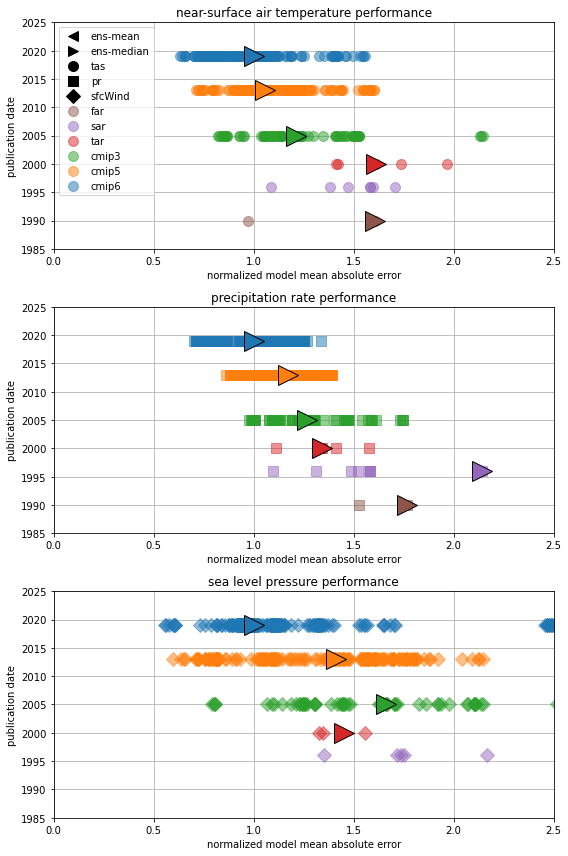

In [11]:
plt.figure(figsize=(8,12))

plt.subplot(len(plot_varnames),1,1)
ens_mean_label = "ens-mean"
plt.plot([], [], 'k<', markersize=10, label=ens_mean_label)
plt.plot([], [], 'k>', markersize=10, label='ens-median')

plt.plot([], [], 'k', marker=var_shape['tas'], markersize=10, label='tas', linewidth=0.)
plt.plot([], [], 'k', marker=var_shape['pr'], markersize=10, label='pr', linewidth=0.)
plt.plot([], [], 'k', marker=var_shape['psl'], markersize=10, label='sfcWind', linewidth=0.)

for key, ens in ens_dict.items():
    
    subplot_count = 1
    for var_key in var_shape.keys():
        
        if var_key not in mae_dict[key]: continue
        
        if var_key == 'tas':
            ens_label = key
        else:
            ens_label = None
            
        plt.subplot(len(plot_varnames),1,subplot_count)
        
        not_mean_list = [key for key in ens.ensemble.values if key!='ens-mean']
        data = mae_skill_score_dict[key][var_key].sel(ensemble=not_mean_list)
        plt.plot(data,mip_year_dict[key]*np.ones_like(data),
                 var_shape[var_key], markersize=10, alpha=0.5, label=ens_label, color=mip_col[key])

#         data = mae_skill_score_dict[key][var_key].sel(ensemble='ens-mean')
#         plt.plot(data, mip_year_dict[key]*np.ones_like(data),
#              marker='<', markersize=20, color=mip_col[key], markeredgecolor='k')
        
        data = mae_skill_score_dict[key][var_key].sel(
            ensemble=[e for e in list(mae_skill_score_dict[key].ensemble.values) if ('ens-mean' != e)]
        ).median(skipna=True)
        plt.plot(data, mip_year_dict[key]*np.ones_like(data),
             marker='>', markersize=20, color=mip_col[key], markeredgecolor='k')
        
        subplot_count+=1
    
var_longname = ['near-surface air temperature', 'precipitation rate', 'sea level pressure']
var_minlim = [0.0, 0.0, 0.0]
var_maxlim = [2.5, 2.5, 2.5]
for subplot_count in range(len(plot_varnames)):
    
    plt.subplot(len(plot_varnames),1,subplot_count+1)
    plt.ylim([1985,2025])
    plt.xlim([var_minlim[subplot_count], var_maxlim[subplot_count]])
    plt.ylabel('publication date')
    plt.xlabel('normalized model mean absolute error')
    if subplot_count == 0: plt.legend()
    plt.title(var_longname[subplot_count]+' performance')
    plt.grid(True)
    
plt.tight_layout()
plt.savefig("../figures/model_performance_over_time.png",bbox_inches='tight',dpi=100)